# Introduction

In this Notebook, we will query Twitter API to stream us all tweet with a specific keyword. Using the model trained in "Model's notebook", we will predict the sentiment of every tweet prior to store them into a NoSQL database done with MongoDB.

As a trial, I'll record all tweets from match France vs Argentina during the World Cup 2018 to do a further exploration on a futur Notebook.

# Creation of the Stream and Database

In [17]:
import os
import datetime

import tweepy  # library to query twitter
import text_prediction  # library to predict the sentiment (reuse model trained in Model's notebook)

import pymongo
from pymongo import MongoClient

In [18]:
# key are requested on Twitter (they are not shared as they are private for every apps we register on Twitter)
with open("key.txt", "r", encoding="utf-8") as f:
    for line in f:
        key, value = line.split(":")
        if key =="ACCESS_TOKEN" :
            ACCESS_TOKEN = value[:-1]
        if key =="ACCESS_SECRET" :
            ACCESS_SECRET = value[:-1]
        if key =="CONSUMER_KEY" :
            CONSUMER_KEY = value[:-1]
        if key =="CONSUMER_SECRET" :
            CONSUMER_SECRET = value[:-1]

In [19]:
# required due to model serialization
def dummy_fun(doc):
    return doc

# Class which load the models into memory and process a sentence to sentiment
p = text_prediction.Text_Processor()

In [20]:
# Connect to MongoDB hosted in localhost on port 27017
client = MongoClient('localhost', 27017)

db = client['Twitter_db']
collection_clean = db['tweets_clean']
# collection_raw = db['tweets_raw']

In [21]:
# log into twitter API
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
api = tweepy.API(auth)

In [22]:
# Class to handle the stream of tweets
class MyStreamListener(tweepy.StreamListener):

    def on_status(self, status):
        tweet = status._json
        try:
            if "text" in tweet:
                obj = {}
                keep = True
                
                obj["_id"] = tweet["id"]
                
                if "extended_tweet" in tweet:
                    obj["text"] = tweet["extended_tweet"]["full_text"]
                elif "text" in tweet:
                    obj["text"] = tweet["text"]
                else:
                    keep = False
                
                if obj["text"][:4] == "RT @":
                    keep = False
                
                if keep:
                    obj["time"] = datetime.datetime.fromtimestamp(int(tweet["timestamp_ms"])//1000)
                    hashtags = []
                    for hashtag in tweet["entities"]["hashtags"]:
                        if len(hashtag) > 0:
                            hashtags.append(hashtag["text"])
                    obj["hashtags"] = hashtags
                    
                    tokens, pred = p.predict(obj["text"])
                    
                    obj["sentiment"] = pred
                    obj["tokens"] = tokens
                    
                    collection_clean.insert_one(obj)
#                     collection_raw.insert_one(tweet)
        except AttributeError as Attr_err:
            print(Attr_err)
            pass
        except pymongo.errors.DuplicateKeyError:
            print(obj["_id"], "duplicated")
            pass
    
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
        
myStreamListener = MyStreamListener()

In [23]:
# Start the stream and store processed tweet to MongoDB
try:
    myStream.disconnect()
except:
    pass

myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)
myStream.filter(track=['#FRAARG'], languages=["en"]) #, async=True

1013053797113978880 duplicated
1013058077929730048 duplicated
1013058077929730048 duplicated
1013058578645684224 duplicated
1013058843859922944 duplicated
1013060042931757057 duplicated
1013062114187964416 duplicated
1013062354794188800 duplicated
1013062615944310785 duplicated
1013063064575496192 duplicated
1013063122246987777 duplicated
1013063363234914305 duplicated
1013063789888135168 duplicated
1013064712165224449 duplicated
1013065140315406337 duplicated
1013065346587222016 duplicated
1013065624438763520 duplicated
1013065878395674624 duplicated
1013065897613783042 duplicated
1013067637956284416 duplicated
1013068407703392257 duplicated
1013068904011259904 duplicated
1013069149461975040 duplicated
1013069656113008640 duplicated
1013070143943999488 duplicated
1013070155444654080 duplicated
1013070157441187841 duplicated
1013070202915999746 duplicated
1013070409305116678 duplicated
1013070408516554752 duplicated
1013070659147173888 duplicated
1013070662355701760 duplicated
10130711

KeyboardInterrupt: 

In [24]:
myStream.disconnect()

# Results

In [25]:
import json
import datetime

from bson import json_util

import matplotlib.pyplot as plt

import pymongo
from pymongo import MongoClient

In [26]:
client = MongoClient('localhost', 27017)

db = client['Twitter_db']
collection_clean = db['tweets_clean']

In [33]:
# first tweet saved
print(json.dumps(collection_clean.find_one(), indent=4, default=json_util.default))

{
    "_id": 1013053260956098561,
    "text": "Come on France. #worldcup2018 #FRAARG",
    "time": {
        "$date": 1530372893000
    },
    "hashtags": [
        "worldcup2018",
        "FRAARG"
    ],
    "sentiment": 0.6849161215932269,
    "tokens": [
        "come",
        "on",
        "franc"
    ]
}


In [39]:
pipeline_sort = {
                    "$sort": {
                        "_id" : 1
                    }
                }

pipeline_group = { 
                    "$group" : 
                        { 
                            "_id" : { 
                                "year": { "$year": "$time" },
                                "month": { "$month": "$time" },
                                "day": { "$dayOfMonth": "$time" },
                                "hour": { "$hour": "$time" },
                                "minute": { "$minute": "$time" },
                            },
                            "count" : { 
                                "$sum" : 1 
                            },
                            "sentiment_global" : { 
                                "$avg" : "$sentiment" 
                            },
#                             "res" : { 
#                                 "$push" : { "$divide": [ {"$trunc": { "$multiply": [ "$sentiment" , 1000 ] } }, 1000 ] }
#                             },
#                             "key" : {
#                                 "$push" : "$tokens" 
#                             },
                            "maxi" : { 
                                "$max" : "$sentiment" 
                            },
                            "mini" : { 
                                "$min" : "$sentiment" 
                            },
                        }
                    }


pipeline = [
    pipeline_group,
    pipeline_sort
]

cursor = collection_clean.aggregate(pipeline)

In [38]:
for i, each in enumerate(cursor):
    print(json.dumps(each, indent=4, default=json_util.default))
    break

{
    "_id": {
        "year": 2018,
        "month": 6,
        "day": 30,
        "hour": 15,
        "minute": 34
    },
    "count": 8,
    "sentiment_global": 0.7055819751784014,
    "maxi": 0.8557995837767274,
    "mini": 0.4663488250645606
}


In [40]:
x = []
y_max = []
y_min = []
y_avg = []
nb = []
for i, each in enumerate(cursor):
    x.append(datetime.datetime(year = each["_id"]["year"], 
                          month = each["_id"]["month"], 
                          day = each["_id"]["day"], 
                          hour = each["_id"]["hour"], 
                          minute = each["_id"]["minute"]))
    y_max.append(each["maxi"])
    y_min.append(each["mini"])
    y_avg.append(each["sentiment_global"])
    nb.append(each["count"])

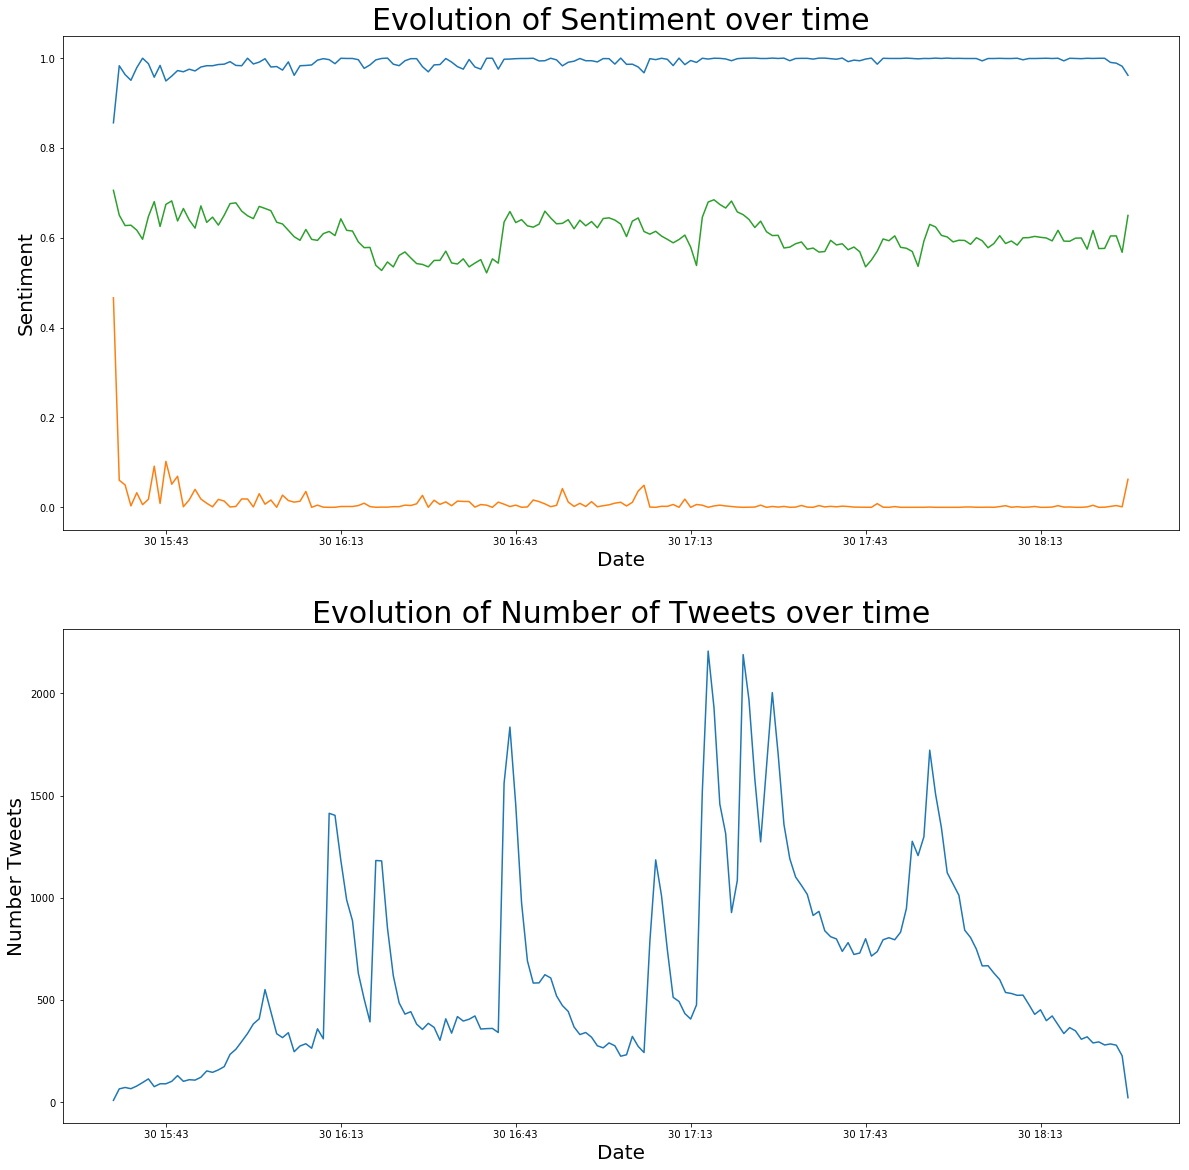

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 20))
ax1.plot(x, y_max, label="sentiment max")
ax1.plot(x, y_min, label="sentiment min")
ax1.plot(x, y_avg, label="sentiment avg")
ax1.set_xlabel("Date", fontsize=20)
ax1.set_ylabel("Sentiment", fontsize=20)
ax1.set_title("Evolution of Sentiment over time", fontsize=30)

ax2.plot(x, nb)
ax2.set_title("Evolution of Number of Tweets over time", fontsize=30)
ax2.set_xlabel("Date", fontsize=20)
ax2.set_ylabel("Number Tweets", fontsize=20)
plt.show()

We can see some peaks (9 in total) related to most probably the 7 goals and 2 other actions. This is where we will dig more in details in a future Notebook. In term of sentiments, our model is not perfect at it is evaluating only words and we have often few of them as it is tweet. As a result, the trend si not really visible. The average has only few peaks also related most probably to goals.

# Conclusion

In this Notebook, we took a look at the twitter API to stream tweet. A NoSQL database has been used to store the content and we used the model of Sentiment Analysis trained previously to see the trend.

As the sentiment Analysis is not good enougth to highlight trends. We will explore more in depth the content of tweet later.